In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import gc
import sys
import warnings
import pickle
from pathlib import Path

import ipywidgets as widgets

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

## Load dataset

In [3]:
df_names = ['playerBoxScores', 'teamBoxScores', 'playerTwitterFollowers', 'teamTwitterFollowers', 'awards', 'events',
           'games', 'standings', 'rosters', 'transactions']
path = "data/train_vs/"

train_dict = {}
for index in range(len(df_names)):
    train_dict[df_names[index]] = pd.read_pickle(os.path.join(path,df_names[index]) + "_train.pkl")

In [4]:
df_names = ['seasons', 'teams', 'players', 'awards']
path = "data/"

my_dict = {}
for index in range(len(df_names)):
    my_dict[df_names[index]] = pd.read_csv(os.path.join(path,df_names[index]) + ".csv")

In [5]:
target = pd.read_pickle('data/target_v/nextDayPlayerEngagement_train.pkl')
target = target.drop(['index'], axis = 1)

### Visualize the mean target values (take mean over all the players)

<AxesSubplot:xlabel='engagementMetricsDate'>

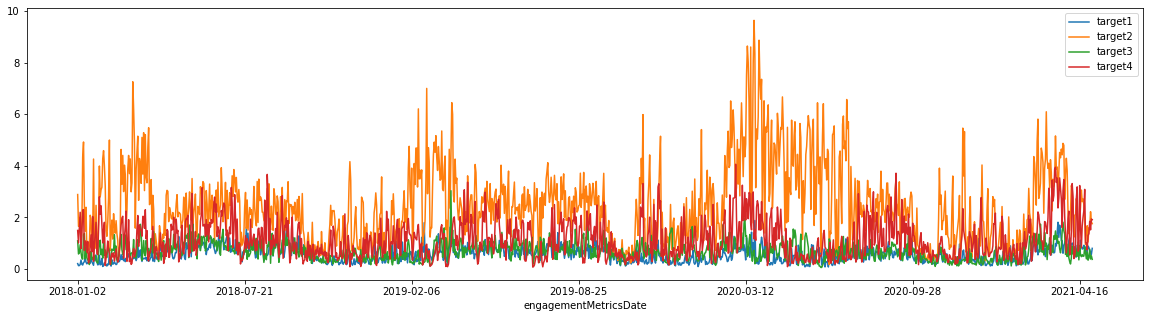

In [6]:
target_date = target.groupby('engagementMetricsDate').mean().drop(['playerId', 'date'], axis = 1)
target_date.plot(figsize=(20,5))

From the plot above, it's clear that the "target2" value has a much bigger variation and the four values are correlated with each other (the correlation is also shown in the matrix below).

<AxesSubplot:>

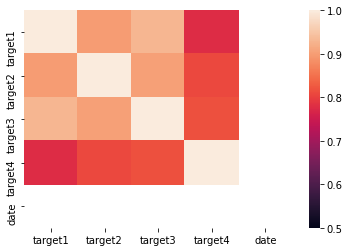

In [7]:
target_player = target.groupby('playerId').mean()
target_corr = target_player.corr()
sns.heatmap(target_corr, vmin = 0.5)

### Seasonal Decomposition

In addition, the 4 values show a seasonal behaviour. To better understand the properties in the 4 time series, we apply a seasonal decomposition to investigate the trend and seasonality.

In [8]:
trend, seasonal = pd.DataFrame(), pd.DataFrame()
for i in target_date:    
    series = target_date[i]
    result = seasonal_decompose(series, model='multiplicative', period = 365)
    trend[i] = result.trend
    seasonal[i] = result.seasonal

The trend-cycle shows the overall movement in the series, ignoring the seasonality and any small random fluctuations.

From the trend component below, we find that target1 and target2 have an almost oppsite trend and target4's trend is totally different from the other 3 measurements.

* For target1, it goes down from the end of 2019 and remained low until around July next year (the late start of the season in 2020 due to covid).
* For target2, it increases when target1 decreases and started to decrease when target1 start to rise.
* For target3, it drop sharply from July 2019 and started to fluctuate from July.
* Target 4 is the only target value that has a cycle, the single cycle period is about 3-4 months.

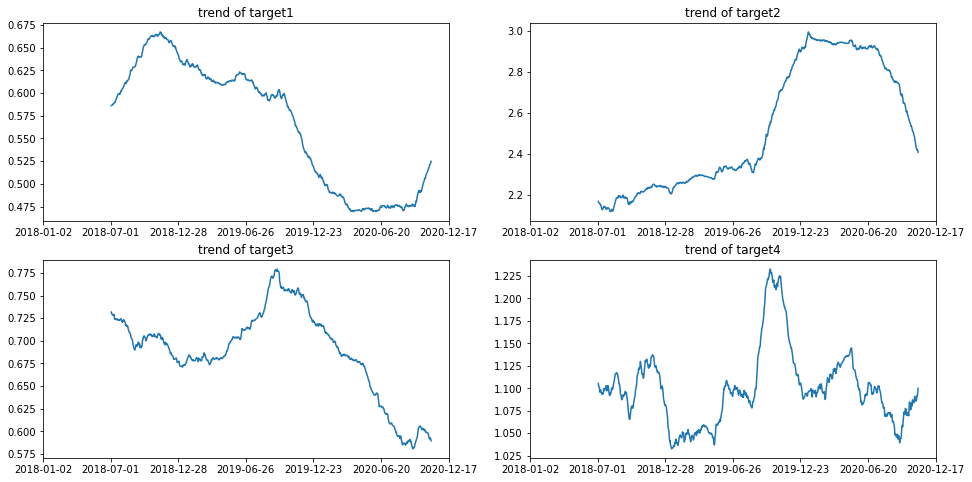

In [9]:
fig, axes = plt.subplots(2, 2, figsize = (16, 8))
axes[0, 0].plot(trend['target1'])
axes[0, 0].set_title('trend of target1')
axes[0, 0].set_xticks(trend.index[::180])
axes[0, 1].plot(trend['target2'])
axes[0, 1].set_title('trend of target2')
axes[0, 1].set_xticks(trend.index[::180])
axes[1, 0].plot(trend['target3'])
axes[1, 0].set_title('trend of target3')
axes[1, 0].set_xticks(trend.index[::180])
axes[1, 1].plot(trend['target4'])
axes[1, 1].set_title('trend of target4')
axes[1, 1].set_xticks(trend.index[::180])

The seasonality plot shows that all the target measurements have a roughly one-year pattern. Ttarget 1 value shows a very obvious spike around March every year. It should be related to the start of each season. Target 2 and 3 also reach peak around March but they fluctuate before and after the peak. From target 1 to 4, the seasonal behaviour is becoming less and less obvious. As for target 4, it shows a big variation throughout the year, instead of seasonality. 

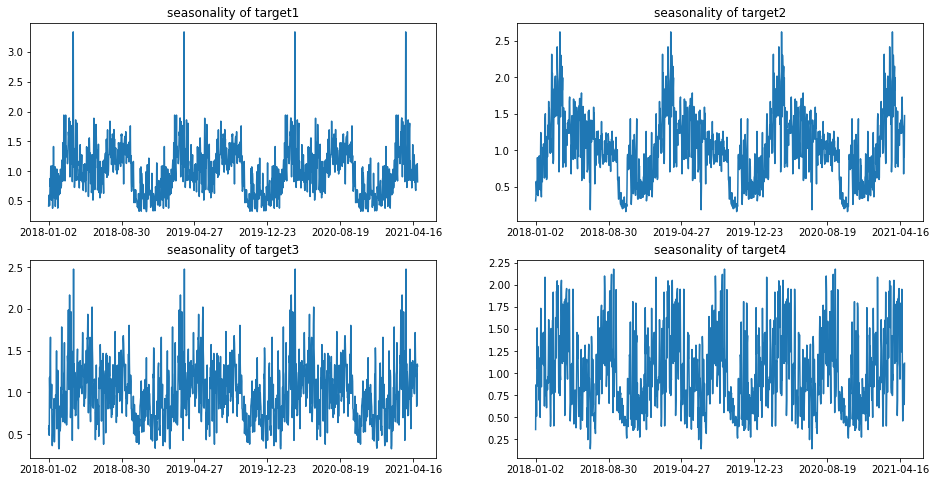

In [10]:
fig, axes = plt.subplots(2, 2, figsize = (16, 8))
axes[0, 0].plot(seasonal['target1'])
axes[0, 0].set_title('seasonality of target1')
axes[0, 0].set_xticks(seasonal.index[::240])
axes[0, 1].plot(seasonal['target2'])
axes[0, 1].set_title('seasonality of target2')
axes[0, 1].set_xticks(seasonal.index[::240])
axes[1, 0].plot(seasonal['target3'])
axes[1, 0].set_title('seasonality of target3')
axes[1, 0].set_xticks(seasonal.index[::240])
axes[1, 1].plot(seasonal['target4'])
axes[1, 1].set_title('seasonality of target4')
axes[1, 1].set_xticks(seasonal.index[::240])

## Find Important Features

We have find the the target values are related with time. In this part, we are going to explore other features (features related to players, teams, and games, etc).

### Construct player related features

In [11]:
player_score = train_dict['playerBoxScores']

I construct features according to the following page: [MLB stats GLOSSARY](http://www.mlb.com/glossary/). 

I choose 2 features from the "Defense" category:
* "FPCT"
* "Out"

5 features from the "Offense" category:
* "HR"
* "IBB"
* "TB"
* "RBI"
* "AVG"

5 features from the "Pitching" category:
* "SV_percnt"
* "HLD"
* "BS"
* "IR"
* "IP"

5 features from the "Advanced" category:
* "ISO"
* "BABIP"
* "RC"
* "PA/SO"
* "K/BB". 

In [12]:
perform_stats = pd.DataFrame()

# For calculation
perform_stats['AB'] = player_score['atBats']
perform_stats['B2'] = player_score['doubles']
perform_stats['B3'] = player_score['triples']
perform_stats['H'] = player_score['hits']
perform_stats['PA'] = player_score['plateAppearances']
perform_stats['TB'] = player_score['totalBases']
perform_stats['BB'] = player_score['baseOnBalls']
perform_stats['SO'] = player_score['strikeOuts']

# Defense
perform_stats['FPCT'] = (player_score['putOuts'] + player_score['assists']) / player_score['chances']
perform_stats['Out'] = player_score['putOuts'] + player_score['groundOuts'] + player_score['strikeOuts'] + player_score['flyOuts']

# Offence
perform_stats['HR'] = player_score['homeRuns']
perform_stats['IBB'] = player_score['intentionalWalks']
perform_stats['TB'] = player_score['totalBases']
perform_stats['RBI'] = player_score['rbi']
perform_stats['AVG'] = perform_stats['H']/perform_stats['AB']

# Pitching
perform_stats['SV_percnt'] = player_score['saves']/player_score['saveOpportunities']
perform_stats['HLD'] = player_score['holds']
perform_stats['BS'] = player_score['blownSaves']
perform_stats['IR'] = player_score['inheritedRunners']
perform_stats['IP'] = player_score['inningsPitched']

# Advanced Offence
perform_stats['ISO'] = (perform_stats['B2']+2*perform_stats['B3']+3*perform_stats['HR'])/perform_stats['AB']
perform_stats['BABIP'] = (perform_stats['H'] - perform_stats['HR'])/(
    perform_stats['AB']-perform_stats['SO']-perform_stats['HR']+player_score['sacFlies'])
perform_stats['RC'] = perform_stats['TB']*(perform_stats['H']+perform_stats['BB'])/(
    perform_stats['AB']+perform_stats['BB'])
perform_stats['PA/SO'] = perform_stats['PA']/perform_stats['SO']
perform_stats['K/BB'] = perform_stats['SO']/perform_stats['BB']

In [15]:
target['date'] = target['date']
target = target[target['date'].notna()]
player_stats = perform_stats[['FPCT', 'Out', 'HR', 'IBB', 'TB', 'RBI', 'AVG', 'SV_percnt', 'HLD', 'BS', 'IR', 'IP', 'ISO', 'BABIP', 'RC', 'PA/SO', 'K/BB']]
player_stats['date'], player_stats['playerId'] = player_score['date'], player_score['playerId']

merge_1 = target.merge(player_stats, on = ['date', 'playerId'], how = 'left')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


I then construct some similar features using the team scores. And I add an team specific measurement:
* "Pytha_WR":

In [16]:
team_score = train_dict['teamBoxScores']

In [17]:
team_stats = pd.DataFrame()

# For fcalculation
team_stats['AB_team'] = team_score['atBats']
team_stats['B2_team'] = team_score['doubles']
team_stats['B3_team'] = team_score['triples']
team_stats['H_team'] = team_score['hits']
team_stats['PA_team'] = team_score['plateAppearances']
team_stats['BB_team'] = team_score['baseOnBalls']
team_stats['SO_team'] = team_score['strikeOuts']

# Offence
team_stats['HR_team'] = team_score['homeRuns']
team_stats['IBB_team'] = team_score['intentionalWalks']
team_stats['TB_team'] = team_score['totalBases']
team_stats['RBI_team'] = team_score['rbi']
team_stats['AVG_team'] = team_stats['H_team']/team_stats['AB_team']

# Pitching
team_stats['IR_team'] = team_score['inheritedRunners']
team_stats['IP_team'] = team_score['inningsPitched']

# Advanced Offence
team_stats['ISO_team'] = (team_stats['B2_team']+2*team_stats['B3_team']+3*team_stats['HR_team'])/team_stats['AB_team']
team_stats['BABIP_team'] = (team_stats['H_team'] - team_stats['HR_team'])/(
    team_stats['AB_team']-team_stats['SO_team']-team_stats['HR_team']+team_score['sacFlies'])
team_stats['RC_team'] = team_stats['TB_team']*(team_stats['H_team']+team_stats['BB_team'])/(
    team_stats['AB_team']+team_stats['BB_team'])
team_stats['Pytha_WR'] = team_score['runsScored']**2/(team_score['runsScored']**2 + team_score['runsPitching']**2)

In [18]:
merge_1['teamId'] = player_score['teamId']
team_stats = team_stats[['HR_team', 'IBB_team', 'TB_team', 'RBI_team', 'AVG_team', 'IR_team', 'IP_team', 'ISO_team', 'BABIP_team', 'RC_team', 'Pytha_WR']]
team_stats['date'], team_stats['teamId'] = team_score['date'], team_score['teamId']
merge_2 = merge_1.merge(team_stats, on = ['date', 'teamId'], how = 'left')

In [19]:
team_rank = train_dict['standings'][['teamId', 'divisionRank', 'leagueRank', 'wildCardRank', 'divWins', 'alWins', 'nlWins', 'pct', 'homeWins', 'xWinLossPct', 'date']]

In [20]:
merge_3 = merge_2.merge(team_rank, on = ['date', 'teamId'], how = 'left')

In [21]:
transaction = train_dict['transactions'][['playerId', 'date', 'typeCode']]
transaction['transacted'] = 1

merge_4 = merge_3.merge(transaction, on = ['date', 'playerId'], how = 'left')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
awards_current = train_dict['awards'][['date', 'playerId']]
awards_current['awarded_recnt'] = 1
merge_5 = merge_4.merge(awards_current, on = ['date', 'playerId',], how = 'left')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
player_twit = train_dict['playerTwitterFollowers'][['date', 'playerId', 'numberOfFollowers']]

merge_6 = merge_5.merge(player_twit, on = ['date', 'playerId'], how = 'left')

In [24]:
team_twit = train_dict['teamTwitterFollowers'][['date', 'teamId', 'numberOfFollowers']]
team_twit = team_twit.rename(columns = {"numberOfFollowers": "team_followers"})

merge_7 = merge_6.merge(team_twit, on = ['date', 'teamId'], how = 'left')

In [25]:
rosters = train_dict['rosters'][['playerId', 'date', 'status']]
merge_8 = merge_7.merge(rosters, on = ['playerId', 'date'], how = 'left')

### Prepare data for random forest

In [26]:
df = merge_8.drop(['engagementMetricsDate'], axis = 1)

In [27]:
df['pct'] = df['pct'].astype('float')

In [28]:
object_encode = df.select_dtypes(include=['object'])

def label_encode(df, column):
    func = {c: i for i, c in enumerate(df[column].unique()) if not pd.isna(c)}
    df[column] = df[column].map(func)

for col in object_encode.columns:
    label_encode(object_encode, col)
df[object_encode.columns] = object_encode

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [29]:
df.replace(np.inf, 0, inplace=True)
df = df.fillna(-99)

#### Construct time features

In [30]:
df['date'] = pd.to_datetime(df['date'], format = "%Y%m%d")
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

In [31]:
df = df.set_index(['playerId', 'date'], drop = True)

In [32]:
player_perform = ['FPCT', 'Out', 'HR', 'IBB', 'TB', 'RBI', 'AVG', 'SV_percnt', 'HLD', 'BS', 'IR', 'IP', 'ISO', 'BABIP', 'RC', 'PA/SO', 'K/BB']
team_perform = ['teamId', 'HR_team', 'IBB_team', 'TB_team', 'RBI_team', 'AVG_team', 'IR_team', 'IP_team', 'ISO_team', 'BABIP_team', 'RC_team', 'Pytha_WR']
team_features = ['divisionRank', 'leagueRank', 'wildCardRank', 'divWins', 'alWins', 'nlWins', 'pct', 'homeWins', 'xWinLossPct', 'team_followers']
player_features = ['typeCode', 'transacted', 'numberOfFollowers', 'status']
time_features = ['year', 'month','day']

### Run Random Forest Model and Extract Feature Importance

In [33]:
regr = RandomForestRegressor(
    max_depth=20, 
    max_features = 'sqrt', 
    min_samples_split = 6, 
    n_estimators = 200, 
    random_state=0)

In [34]:
X = df.drop(['target1', 'target2', 'target3', 'target4'], axis = 1)
y = df[['target1', 'target2', 'target3', 'target4']]

In [35]:
%%time
feature_imp = pd.DataFrame(index = X.columns)
for i in y.columns:
    if os.path.isfile("../input/rf-models/" + i + "_model.sav"):
        with open("../input/rf-models/" + i + "_model.sav", 'rb') as fin:
            regr = pickle.load(fin)
            feature_imp[i] = regr.feature_importances_
    else:
        regr = regr.fit(X, y[i])
        feature_imp[i] = regr.feature_importances_
        filename = i+'_model.sav'
        pickle.dump(regr, open('rf_models/esti_200/'+ filename, 'wb'))

Wall time: 17min 18s


In [36]:
for i in feature_imp.index:
    if i in player_perform:
        feature_imp.loc[i, 'color'] = 'r'
    elif i in player_features:
        feature_imp.loc[i, 'color'] = 'y'
    elif i in team_perform:
        feature_imp.loc[i, 'color'] = 'g'
    elif i in team_features:
        feature_imp.loc[i, 'color'] = 'b'
    else:
        feature_imp.loc[i, 'color'] = 'cyan'

In [37]:
y1_imp = feature_imp[['target1', 'color']].sort_values(by=['target1'], ascending = True)
y2_imp = feature_imp[['target2', 'color']].sort_values(by=['target2'], ascending = True)
y3_imp = feature_imp[['target3', 'color']].sort_values(by=['target3'], ascending = True)
y4_imp = feature_imp[['target4', 'color']].sort_values(by=['target4'], ascending = True)

From the 4 feature importance below, we can see that all the features are related to time features (the cyan bar). Except for this, the players' performance (red bar), status and twitter followers (yellow bar) are the most important for all the target measurements. However, team performance (green bar) and rankings (blue) in a season do not have much influence.

Text(0.5, 1.0, 'feature importance for y4')

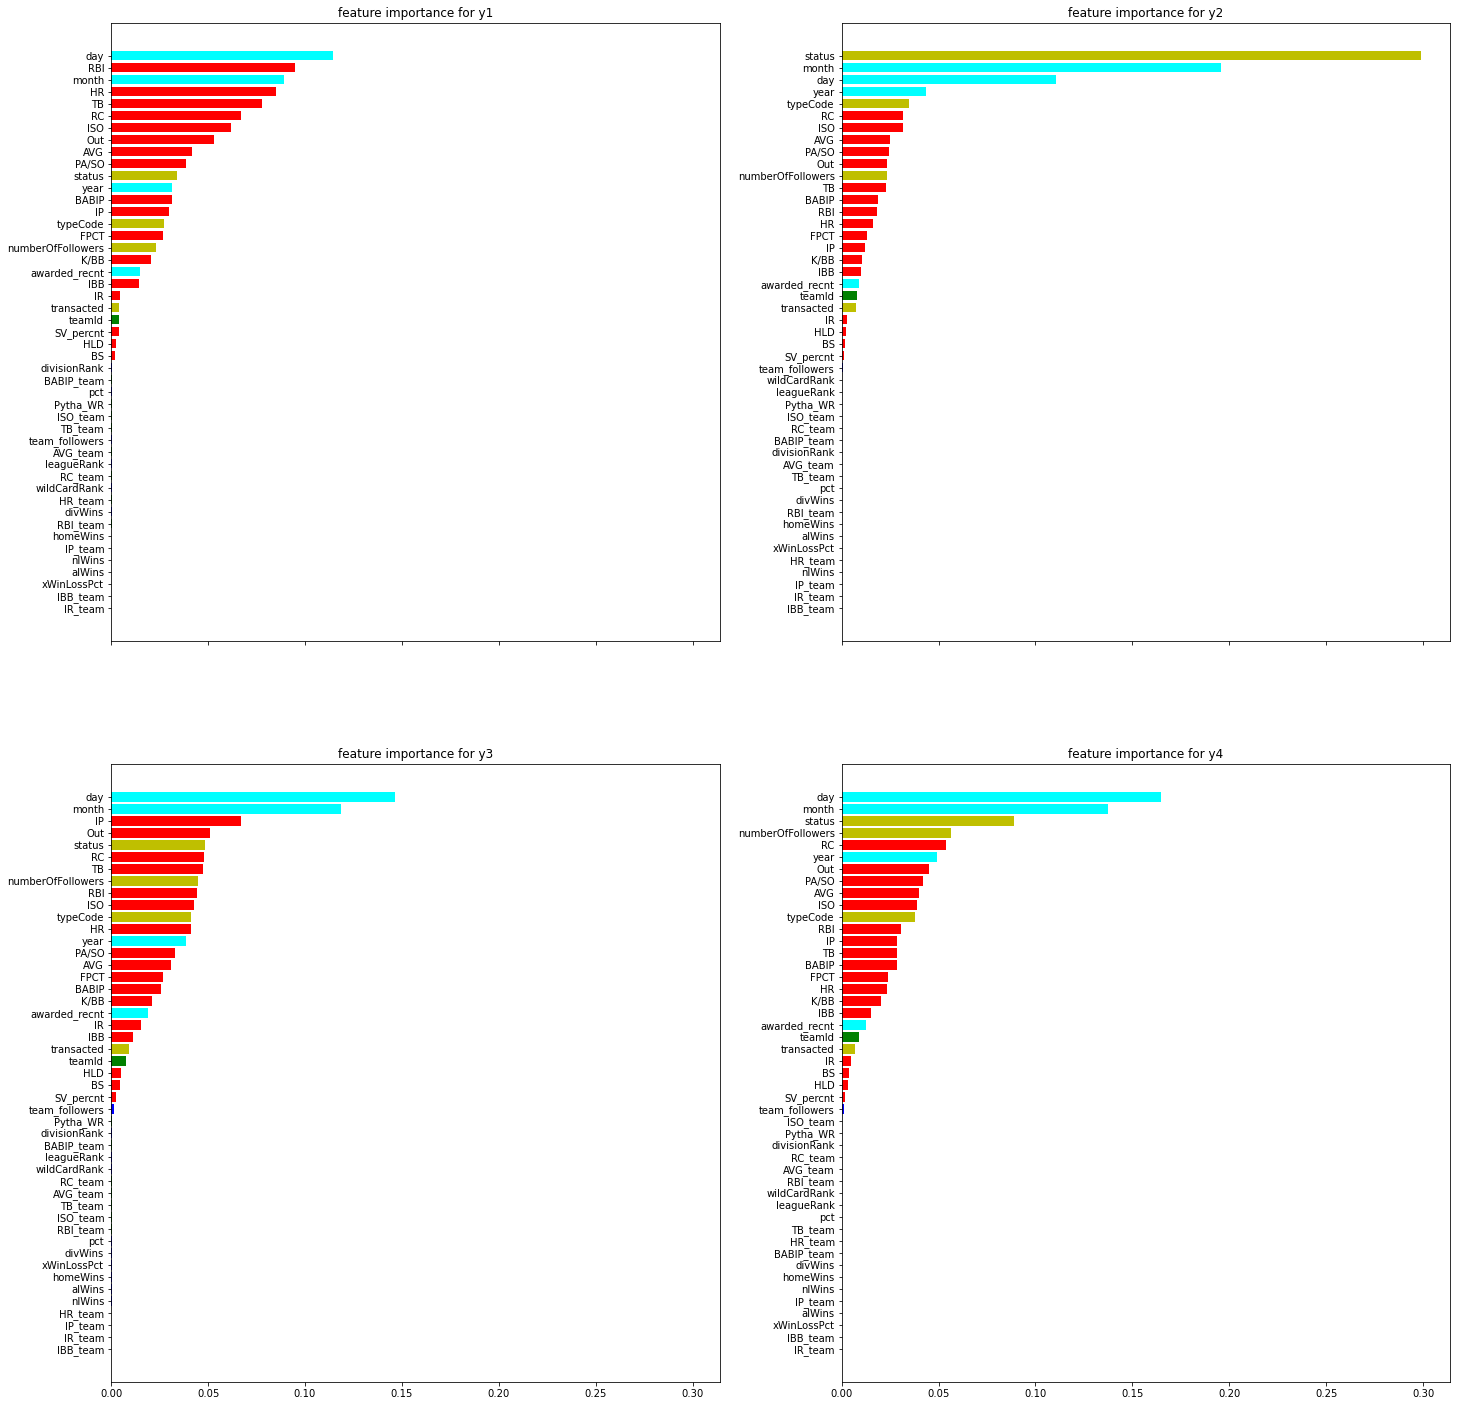

In [38]:
fig, axs = plt.subplots(2, 2, figsize = (24,25), sharex = True)
axs[0, 0].barh(y1_imp.index, y1_imp['target1'], color = y1_imp.color.values)
axs[0, 0].set_title('feature importance for y1')
axs[0, 1].barh(y2_imp.index, y2_imp['target2'], color = y2_imp.color.values)
axs[0, 1].set_title('feature importance for y2')
axs[1, 0].barh(y3_imp.index, y3_imp['target3'], color = y3_imp.color.values)
axs[1, 0].set_title('feature importance for y3')
axs[1, 1].barh(y4_imp.index, y4_imp['target4'], color = y4_imp.color.values)
axs[1, 1].set_title('feature importance for y4')

If we enlarge the above 4 pictures and focus on the first 10 features, we can see that except for status, time feature "day" and "month" and some player performance related features are the most important. But for different target measurement, the most influential features are slightly different.

* For target 1, "day" is the most important feature, and the other 8 features are all related to player performance in a game. 

* For target 2, the "status" of the player ranks the first, followed by 3 time features. And the other 6 features are combination of player performance and other player related features. 

* For target 3  and feature 4 are similar, they are both related to a combination of time features, player performance and player twitter and status.

Text(0.5, 1.0, 'feature importance for y4')

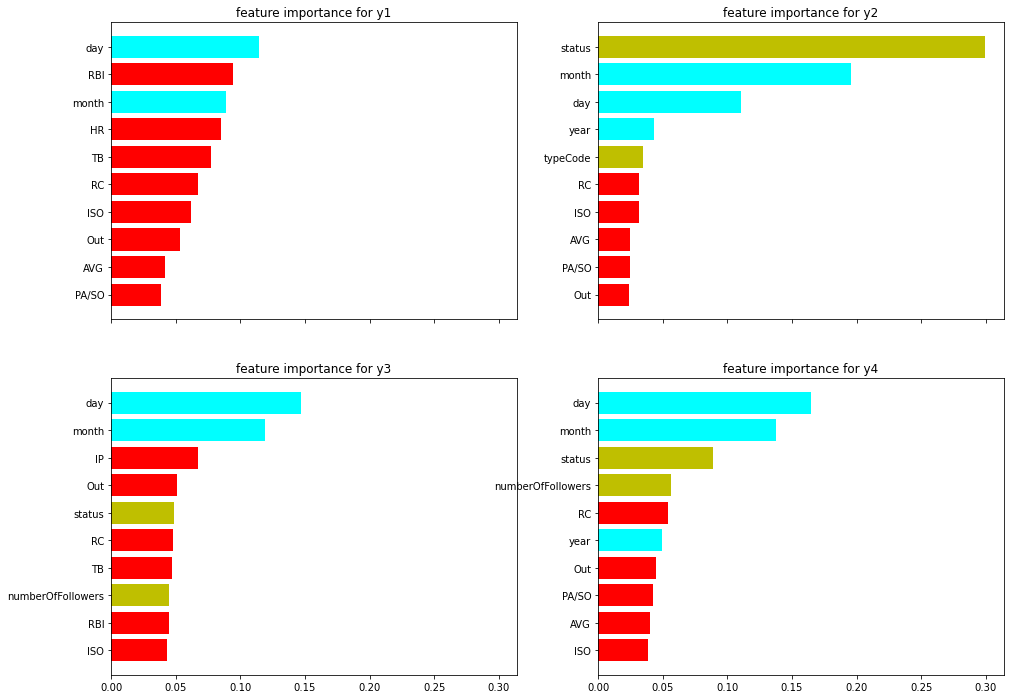

In [40]:
fig, axs = plt.subplots(2, 2, figsize = (16,12), sharex = True)
axs[0, 0].barh(y1_imp[-10:].index, y1_imp['target1'][-10:], color = y1_imp[-10:].color.values)
axs[0, 0].set_title('feature importance for y1')
axs[0, 1].barh(y2_imp[-10:].index, y2_imp['target2'][-10:], color = y2_imp[-10:].color.values)
axs[0, 1].set_title('feature importance for y2')
axs[1, 0].barh(y3_imp[-10:].index, y3_imp['target3'][-10:], color = y3_imp[-10:].color.values)
axs[1, 0].set_title('feature importance for y3')
axs[1, 1].barh(y4_imp[-10:].index, y4_imp['target4'][-10:], color = y4_imp[-10:].color.values)
axs[1, 1].set_title('feature importance for y4')

If we look at the percentage of different feature categories, we can see that target 1 is influenced by the player performance the most, while target 2 is not. Target 2 are more influenced by other player features, such as atatus and players' twitter account. Target 3 and 4 are highly influenced by time features, and they are the only two measuments that are influenced by "year". 

In [41]:
grouped_feature = pd.DataFrame(columns = ['player_perform', 'player_features', 'team_perform', 'team_features', 'time_features'])
feature_imp = feature_imp.drop(['color'], axis = 1)

grouped_feature['player_perform'] = feature_imp.T[player_perform].mean(axis = 1)
grouped_feature['player_features'] = feature_imp.T[player_features].mean(axis = 1)
grouped_feature['team_perform'] = feature_imp.T[team_perform].mean(axis = 1)
grouped_feature['team_features'] = feature_imp.T[team_features].mean(axis = 1)
grouped_feature['time_features'] = feature_imp.T[time_features].mean(axis = 1)

Text(0, 0.5, 'Target measurements')

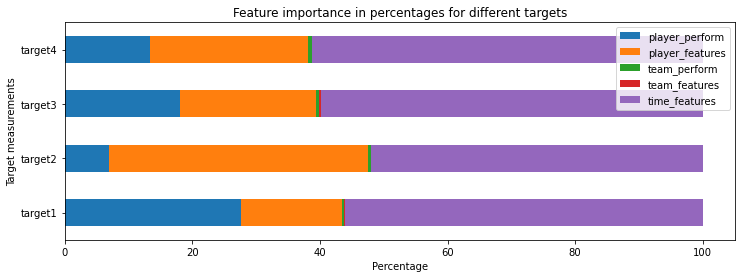

In [42]:
stacked_data = grouped_feature.apply(lambda x: x*100/sum(x), axis=1)
stacked_data

stacked_data.plot(kind="barh", stacked=True, figsize = (12,4))
plt.title("Feature importance in percentages for different targets")
plt.xlabel("Percentage")
plt.ylabel("Target measurements")

In [47]:
player_perform = ['FPCT', 'Out', 'HR', 'IBB','TB', 'RBI', 'AVG', 'SV_percnt', 'HLD', 'BS', 'IR', 'IP', 'ISO', 'BABIP', 'RC', 'PA/SO', 'K/BB']
team_perform = ['teamId', 'HR_team', 'IBB_team', 'TB_team', 'RBI_team', 'AVG_team', 'IR_team', 'IP_team', 'ISO_team', 'BABIP_team', 'RC_team', 'Pytha_WR']
team_features = ['divisionRank', 'leagueRank', 'wildCardRank', 'divWins', 'alWins', 'nlWins', 'pct', 'homeWins', 'xWinLossPct', 'team_followers']
player_features = ['typeCode', 'transacted', 'numberOfFollowers', 'status']

In [48]:
pf = feature_imp.T[player_perform]

defence = ['FPCT', 'Out']
offence = ['HR', 'IBB', 'TB', 'RBI', 'AVG']
pitching = ['SV_percnt', 'HLD', 'BS', 'IR', 'IP']
advanced = ['ISO', 'BABIP', 'RC', 'PA/SO', 'K/BB']

pf['defence'] = pf[defence].mean(axis = 1)
pf['offence'] = pf[offence].mean(axis = 1)
pf['pitching'] = pf[pitching].mean(axis = 1)
pf['advanced'] = pf[advanced].mean(axis = 1)

pf = pf.drop(defence+offence+pitching+advanced, axis = 1).T

pf['mean'] = pf.mean(axis = 1)
pf = pf.sort_values(by = 'mean', ascending = False).drop(['mean'], axis = 1)

<AxesSubplot:>

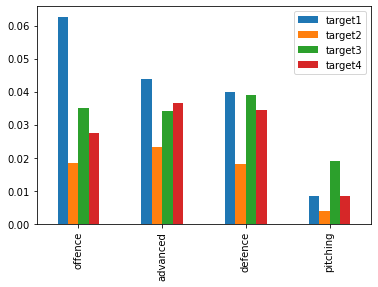

In [49]:
pf.plot(kind = 'bar')

In [57]:
# player_f = feature_imp.T[player_features].T
# player_f['mean'] = player_f.mean(axis = 1)
# player_f = player_f.sort_values(by = 'mean', ascending = False).drop(['mean'], axis = 1)

In [58]:
# player_f.plot(kind = 'bar', figsize = (15,6))

In [56]:
# tf = feature_imp.T[time_features]

# tf['mean'] = tf.mean(axis = 1)
# tf = tf.sort_values(by = 'mean', ascending = False).drop(['mean'], axis = 1)

# tf.plot(kind = 'bar', figsize = (15,6))

From the plot below, it is obvious that player twitter followers are much more important than the number of team followers for all of the 4 targets. Therefore, when combined with the feature importance, we find that although team performance affect the fans' engagement, the popularity of team twitter does not.

<AxesSubplot:>

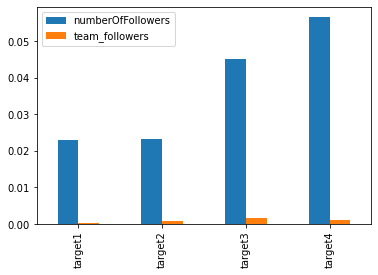

In [53]:
feature_imp.T[['numberOfFollowers', 'team_followers']].plot(kind = 'bar')

In addition, we can see that "target2" value are less related with the number of player twitter followers. We can see a similar trend in the following violin plot:

In [96]:
select_y1 = y1_imp[y1_imp['target1']>0.01].T.columns
select_y2 = y2_imp[y2_imp['target2']>0.01].T.columns
select_y3 = y3_imp[y3_imp['target3']>0.01].T.columns
select_y4 = y4_imp[y4_imp['target4']>0.01].T.columns

In [97]:
df_1 = df[select_y1]
df_2 = df[select_y2]
df_3 = df[select_y3]
df_4 = df[select_y4]

In [98]:
modelpath1 = 'rf_models/esti_200/y1' 
if not os.path.exists(modelpath1):
    os.makedirs(modelpath1)
    
modelpath2 = 'rf_models/esti_200/y2' 
if not os.path.exists(modelpath2):
    os.makedirs(modelpath2)
    
modelpath3 = 'rf_models/esti_200/y3' 
if not os.path.exists(modelpath3):
    os.makedirs(modelpath3)
    
modelpath4 = 'rf_models/esti_200/y4' 
if not os.path.exists(modelpath4):
    os.makedirs(modelpath4)
    
figpath = 'plots/' 
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [99]:
%%time
regr_dict_y1 = {}
feature_imp_y1 = pd.DataFrame(columns = df_1.loc[112526].columns).T
for key in target['playerId'].unique():
    if os.path.isfile("rf_models/esti_200/y1/"+ str(key)+"_model_y1.sav"):
        with open("rf_models/esti_200/y1/"+ str(key)+"_model_y1.sav", 'rb') as fin:
            regr_dict_y1[key] = pickle.load(fin)
            feature_imp_y1[key] = regr_dict_y1[key].feature_importances_
    else:
        regr_dict_y1[key] = regr.fit(df_1.loc[key], y.loc[key]['target1'])
        feature_imp_y1[key] = regr_dict_y1[key].feature_importances_
        filename = str(key)+'_model_y1.sav'
        pickle.dump(regr_dict_y1[key], open("rf_models/esti_200/y1/" + filename, 'wb'))

Wall time: 10min 2s


In [100]:
%%time
regr_dict_y2 = {}
feature_imp_y2 = pd.DataFrame(columns = df_2.loc[112526].columns).T
for key in target['playerId'].unique():
    if os.path.isfile("rf_models/esti_200/y2/"+ str(key)+"_model_y2.sav"):
        with open("rf_models/esti_200/y2/"+ str(key)+"_model_y2.sav", 'rb') as fin:
            regr_dict_y2[key] = pickle.load(fin)
            feature_imp_y2[key] = regr_dict_y2[key].feature_importances_
    else:
        regr_dict_y2[key] = regr.fit(df_2.loc[key], y.loc[key]['target2'])
        feature_imp_y2[key] = regr_dict_y2[key].feature_importances_
        filename = str(key)+'_model_y2.sav'
        pickle.dump(regr_dict_y2[key], open("rf_models/esti_200/y2/" + filename, 'wb'))

Wall time: 10min 19s


In [101]:
%%time
regr_dict_y3 = {}
feature_imp_y3 = pd.DataFrame(columns = df_3.loc[112526].columns).T
for key in target['playerId'].unique():
    if os.path.isfile("rf_models/esti_200/y3/"+ str(key)+"_model_y3.sav"):
        with open("rf_models/esti_200/y3/"+ str(key)+"_model_y3.sav", 'rb') as fin:
            regr_dict_y3[key] = pickle.load(fin)
            feature_imp_y3[key] = regr_dict_y3[key].feature_importances_
    else:
        regr_dict_y3[key] = regr.fit(df_3.loc[key], y.loc[key]['target3'])
        feature_imp_y3[key] = regr_dict_y3[key].feature_importances_
        filename = str(key)+'_model_y3.sav'
        pickle.dump(regr_dict_y3[key], open("rf_models/esti_200/y3/" + filename, 'wb'))

Wall time: 9min 49s


In [102]:
%%time
regr_dict_y4 = {}
feature_imp_y4 = pd.DataFrame(columns = df_4.loc[112526].columns).T
for key in target['playerId'].unique():
    if os.path.isfile("rf_models/esti_200/y4/"+ str(key)+"_model_y4.sav"):
        with open("rf_models/esti_200/y4/"+ str(key)+"_model_y4.sav", 'rb') as fin:
            regr_dict_y4[key] = pickle.load(fin)
            feature_imp_y4[key] = regr_dict_y4[key].feature_importances_
    else:
        regr_dict_y4[key] = regr.fit(df_4.loc[key], y.loc[key]['target4'])
        feature_imp_y4[key] = regr_dict_y4[key].feature_importances_
        filename = str(key)+'_model_y4.sav'
        pickle.dump(regr_dict_y4[key], open("rf_models/esti_200/y4/" + filename, 'wb'))

Wall time: 10min 14s


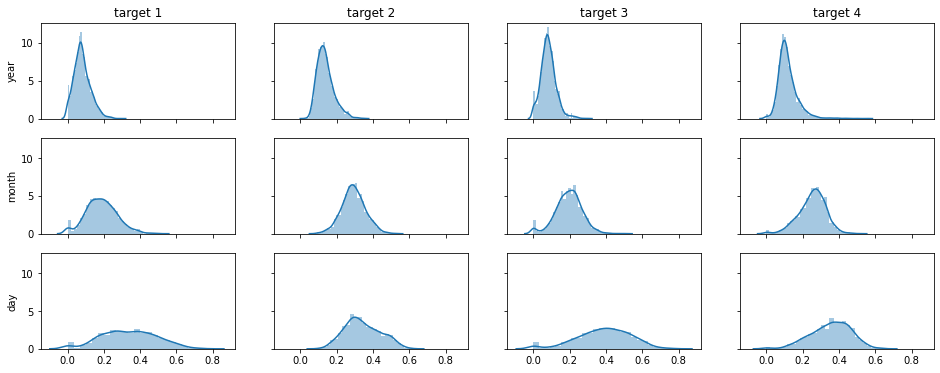

In [315]:
fig, axes = plt.subplots(len(time_features), 4, figsize = (16,6), sharey = True, sharex = True)
fea_list = [feature_imp_y1, feature_imp_y2, feature_imp_y3, feature_imp_y4]
name_list = ['1', '2', '3', '4']
for i,j in enumerate(time_features):
    for k in range(4):
        df_plot = fea_list[k]
        axes[i, k] = sns.distplot(df_plot.T[j], ax = axes[i,k])
        axes[i, k].set_ylabel(j)
        axes[i, k].set_xlabel('')
        if i == 0:
            axes[i, k].set_title('target'+ ' ' + name_list[k])

## What about 2020?

In [202]:
target['engagementMetricsDate'] = pd.to_datetime(target['engagementMetricsDate'], format = "%Y-%m-%d")
target['year'] = target['engagementMetricsDate'].dt.year

In [383]:
target_2020 = target[target['year']==2020].drop(['date', 'year', 'playerId'], axis = 1).groupby(
    'engagementMetricsDate').mean().reset_index()
target_2019 = target[target['year']==2019].drop(['date', 'year', 'playerId'], axis = 1).groupby(
    'engagementMetricsDate').mean().reset_index()
target_2018 = target[target['year']==2018].drop(['date', 'year', 'playerId'], axis = 1).groupby(
    'engagementMetricsDate').mean().reset_index()

In [427]:
value_2020 = target_2020[(target_2020['engagementMetricsDate'] < pd.Timestamp('2020-08-01')) & (
    target_2020['engagementMetricsDate'] > pd.Timestamp('2020-02-29'))].reset_index()
value_2019 = target_2019[(target_2019['engagementMetricsDate'] < pd.Timestamp('2019-08-01')) & (
    target_2019['engagementMetricsDate'] > pd.Timestamp('2019-02-28'))].reset_index()
value_2018 = target_2018[(target_2018['engagementMetricsDate'] < pd.Timestamp('2018-08-01')) & (
    target_2018['engagementMetricsDate'] > pd.Timestamp('2018-02-28'))].reset_index()

In [453]:
diff_2020 = (value_2020 - value_2019)[['target1', 'target2', 'target3', 'target4']].set_index(
    (pd.period_range(start='2020-03-01', end='2020-07-31', freq='d').to_timestamp()))
diff_2019 = (value_2019 - value_2018)[['target1', 'target2', 'target3', 'target4']].set_index(
    (pd.period_range(start='2020-03-01', end='2020-07-31', freq='d').to_timestamp()))

We expect that the target values of 2020 will be lower that 2019, given that the whole year is in covid. However, when we compare the difference between 2020 and 2019, and difference between 2019 and 2018, we find that it's not the case.

For target 1, the value in 2020 is lower than 2019,  while the values were similar between 2019 and 2018.

Text(0.5, 1.0, 'Difference between 2019 and 2018')

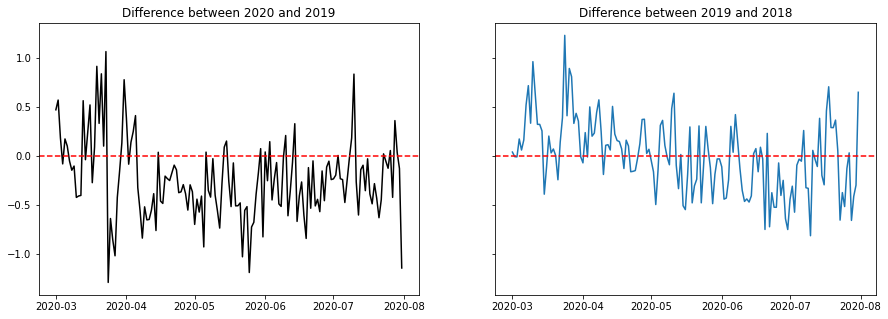

In [454]:
fig, axs = plt.subplots(1, 2, figsize = (15,5), sharey = True)

axs[0].plot(diff_2020['target1'].index, diff_2020['target1'], color='black')
axs[0].axhline(y=0,linestyle='--',color='red')
axs[0].set_title('Difference between 2020 and 2019')
axs[1].plot(diff_2019['target1'].index, diff_2019['target1'])
axs[1].axhline(y=0,linestyle='--',color='red')
axs[1].set_title('Difference between 2019 and 2018')

However, for target 2, the values in 2020 rose obciously. 

Text(0.5, 1.0, 'Difference between 2019 and 2018')

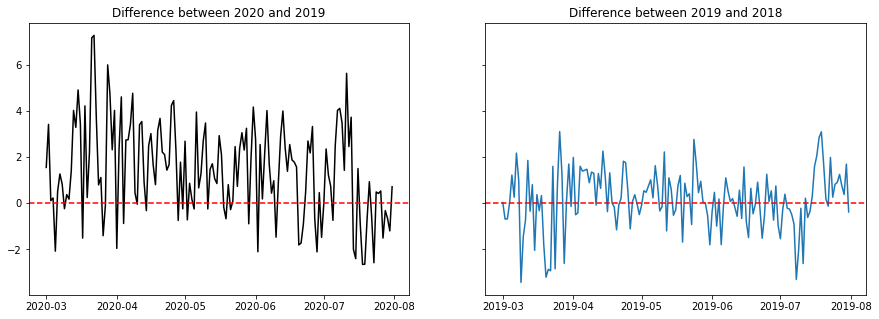

In [447]:
fig, axs = plt.subplots(1, 2, figsize = (15,5), sharey = True)

axs[0].plot(diff_2020['target2'].index, diff_2020['target2'], color='black')
axs[0].axhline(y=0,linestyle='--',color='red')
axs[0].set_title('Difference between 2020 and 2019')
axs[1].plot(diff_2019['target2'].index, diff_2019['target2'])
axs[1].axhline(y=0,linestyle='--',color='red')
axs[1].set_title('Difference between 2019 and 2018')

Target value 3 does not show much difference except for a spike around the start of the season.

Text(0.5, 1.0, 'Difference between 2019 and 2018')

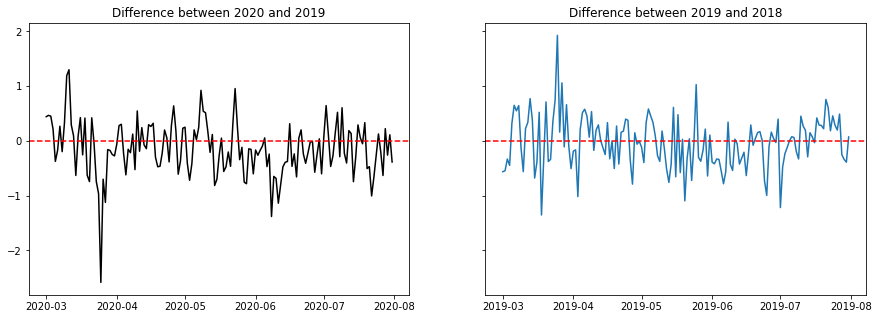

In [448]:
fig, axs = plt.subplots(1, 2, figsize = (15,5), sharey = True)

axs[0].plot(diff_2020['target3'].index, diff_2020['target3'], color='black')
axs[0].axhline(y=0,linestyle='--',color='red')
axs[0].set_title('Difference between 2020 and 2019')
axs[1].plot(diff_2019['target3'].index, diff_2019['target3'])
axs[1].axhline(y=0,linestyle='--',color='red')
axs[1].set_title('Difference between 2019 and 2018')

In [ ]:
There's a slight decrease in target 4 in 2020, but it is not obvous.

Text(0.5, 1.0, 'Difference between 2019 and 2018')

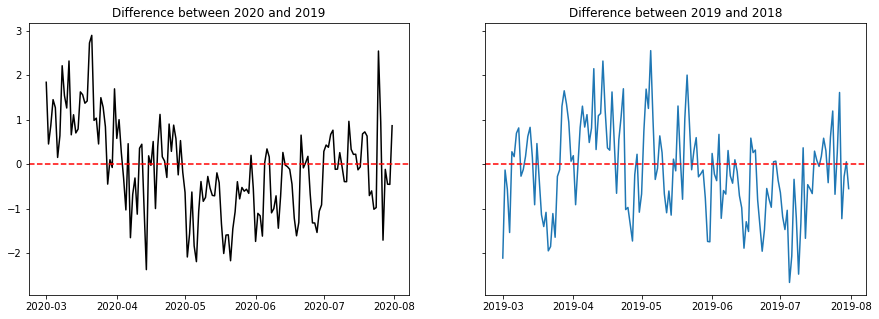

In [449]:
fig, axs = plt.subplots(1, 2, figsize = (15,5), sharey = True)

axs[0].plot(diff_2020['target4'].index, diff_2020['target4'], color='black')
axs[0].axhline(y=0,linestyle='--',color='red')
axs[0].set_title('Difference between 2020 and 2019')
axs[1].plot(diff_2019['target4'].index, diff_2019['target4'])
axs[1].axhline(y=0,linestyle='--',color='red')
axs[1].set_title('Difference between 2019 and 2018')